<img src=https://s.abcnews.com/images/Business/GTY_ncaa_logo_ml_140121_33x16_992.jpg width= "750">

# <center> Predicting Wins in NCAA Men's Basketball </center>
<center> Derek Lore, Christopher Nalty, Michael Stephanus </center>

***

## <center> Introduction </center>

The National Collegiate Athletic Association (<a href= "https://www.ncaa.com/">NCAA</a>) is a nonprofit organization dedicated to the well-being and lifelong success of college athletes. The NCAA was built in 1910 and they essentially  regulates competitions between universities and colleges. They organize athletic programs such as basketball, footbal, soccer, basketball, etc. Currently 1,117 college and universities are a part of the NCAA.

In this tutorial, we will be focusing on basketball. We will collect data about an entire NCAA season and build predictive models whether a team win or lose. We will start by getting the necessary datas to build our models. We will be search for datasets that contain specific statisics that occurs in a basketball game such as the number of turn overs, assists, blocks, rebounds, field goal percentage, etc. We will tidy the data and we will try to find correlations between each statistic and a team's winrate. This all leads up to the purpose of this tutorial, which is whether we can predict whether a team will win a game if they have a certain amount of rebounds, assists, turnovers, etc. Hopefully this tutorial can provide all of you basketball enthusiasts an insight of how these datas can predict the outcome of a game.

### Outline
1. <a href="#Gathering the Data">Gathering the Data</a>
<ul><li>1.1 <a href="#Team Box Scores">Team Box Scores</a></li>
    <li>1.2 <a href="#Team Ranks">Team Ranks</a></li>
    <li>1.3 <a href="#Game Statistics">Game Statistics</a></li></ul>
2. <a href="#Data Cleaning">Data Cleaning</a>
<ul><li>2.1 <a href="#Team Box Scores Cleaning">Team Box Scores Cleaning</a>     </li>
    <li>2.2 <a href="#Team Ranks Cleaning">Team Ranks Cleaning</a></li>
    <li>2.3 <a href="#Game Statistics Cleaning">Game Statistics Cleaning</a>     </li>
    <li>2.4 <a href="#Maping The Names">Maping The Names</a></li></ul>
3. <a href="#Exploratory Data Analysis">Exploratory Data Analysis</a>
<ul><li>3.1 <a href="#Number One Ranked Teams">Number One Ranked Teams</a>       </li>
    <li>3.2 <a href="#Field Goal Percentage Graph">Field Goal Percentage Graph</a></li>
    <li>3.3 <a href="#Average Statistics Graph">Average Statistics Graph</a></li>
    <li>3.4 <a href="#Statisics VS Win Percentage">Statisics VS Win Percentage</a></li></ul>
4. <a href="#Machine Learning">Machine Learning</a>
5. <a href="#Conclusion">Conclusion</a>

## <center><a id="Gathering the Data">Gathering the Data</a></center>

### <a id="Team Box Scores">1.1 Team Box Scores</a>

The First piece of data we're going to gather is all of the game results for Division 1 games in the 2018-2019 season. 
We're going to get that data from a site called [Sports Reference](https://www.sports-reference.com/cbb/boxscores/). 
This site formats there urls for boxscore to include the month, day, and year you're looking at. Using this we can create
a loop do go through all the dates in the season and download the box scores for each game. We add a short sleep after each day
since we're sending a lot get requests to prevent any connection interruptions on either end.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time

box_scores = pd.DataFrame(columns=["date", "win_team", "lose_team", "win_score", "lose_score"])

#The format of the URL. we will continue to increment the month, day, and year
url_format = "https://www.sports-reference.com/cbb/boxscores/index.cgi?month={}&day={}&year={}"
for y in [2018, 2019]:
    months = []
    if y == 2018:
        months = [11, 12]
    else:
        months = [1, 2, 3, 4]
    
    for m in months:
        days = range(1,32)
        for d in days:
            url = url_format.format(str(m),str(d),str(y))
            r = requests.get(url)

            root = BeautifulSoup(r.content)
            root.prettify()
            
            #format the months and days so that they are always 2 digits
            mon = str(m)
            day = str(d)
            if (m < 10):
                mon = "0" + mon
            if (d < 10):
                day = "0" + day
            
            date = str(mon) + "/" + str(day) + "/" + str(y)
    
            #game_summary nohover contains all the table for each match
            #we will iterate through all the tables in the website and parse them one by one
            for i in root.find_all("div", class_="game_summary nohover"):
                loser = i.find("tr", class_="loser")
                lose_team = loser.find("a").getText()
                lose_score = loser.find("td", class_="right").getText()
    
                winner = i.find("tr", class_="winner")
                win_team = winner.find("a").getText()
                win_score = winner.find("td", class_="right").getText()
                
                box_scores = box_scores.append({"date":date, "win_team":win_team, "lose_team":lose_team, "win_score":win_score, "lose_score":lose_score}, ignore_index=True)
            
            time.sleep(0.5)

box_scores.head()

,date,win_team,lose_team,win_score,lose_score
0,11/06/2018,Kansas,Michigan State,92,87
1,11/06/2018,Duke,Kentucky,118,84
2,11/06/2018,Gonzaga,Idaho State,120,79
3,11/06/2018,Virginia,Towson,73,42
4,11/06/2018,Tennessee,Lenoir-Rhyne,86,41


### <a id="Team Ranks">1.2 Team Ranks</a>

The next piece of data we're going to gather is the ranks for each team from the ap polls of each week. We're also going
get this information from [Sports Reference](https://www.sports-reference.com/cbb/seasons/2019-polls.html). This site
has a csv formatted table we can just copy and paste into a file and read with pandas.

In [2]:
ranks = pd.read_csv("apranks.csv") # found here https://www.sports-reference.com/cbb/seasons/2019-polls.html

ranks.head()


,School,Conf,Pre,11/12,11/19,11/26,12/03,12/10,12/17,12/24,...,01/14,01/21,01/28,02/04,02/11,02/18,02/25,03/04,03/11,Final
0,Arizona State,Pac-12,NaN,NaN,NaN,NaN,20.0,20.0,18.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Auburn,SEC,11.0,9.0,8.0,8.0,8.0,8.0,7.0,12.0,...,14.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,14.0
2,Buffalo,MAC,NaN,25.0,22.0,21.0,17.0,14.0,14.0,21.0,...,16.0,14.0,18.0,23.0,25.0,25.0,21.0,19.0,18.0,15.0
3,Cincinnati,AAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25.0,NaN,NaN,23.0,20.0,24.0,22.0
4,Clemson,ACC,22.0,19.0,16.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <a id="Game Statistics">1.3 Game Statistics</a>

The last piece of data we need to do is to acquire all of the team statistical data by week from the NCAA website. This way
we can use to date accurate data for training and validation of our prediction model later on. Using only end of season statistics
could have an effect on the prediction since teams stats will change as a season progresses. The data we're going to be using can be located at [http://web1.ncaa.org/stats/StatsSrv/rankings?sportCode=MBB]. This page requires us to do some clicking, 
and doesn't have all of the stats centralized in one csv. So to automate this we will use selenium, instead of doing ~12000 
clicks ourselves. To do this we used the chrome based webdriver in selenium, to run this script you will need the 
[ChromeDriver](https://chromedriver.chromium.org/downloads). Once we have this installed we can now the following script 
to download every team stat available from every date of the 2018-2019 Men's Basketball season.

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
options = Options()
prefs = {'download.default_directory' : r'/home/chris/git/final320project/stats'}
print(prefs['download.default_directory'])
options.add_experimental_option('prefs', prefs)

driver = webdriver.Chrome("/home/chris/Downloads/chromedriver", chrome_options=options) # change this to where ever your driver is

# select division one button, since that's all we care about, will stay persistent
driver.get("http://web1.ncaa.org/stats/StatsSrv/rankings?sportCode=MBB")
div1 = driver.find_element_by_xpath("/html/body/form/table[3]/tbody/tr[2]/td/select/option[2]").click()
week_base = "/html/body/form/table[3]/tbody/tr[5]/td/select/option[{}]" # base string for selecting week
stats_base = "/html/body/form/table[3]/tbody/tr[10]/td/select/option[{}]" # base for stats

for i in range(2, 142):
    driver.find_element_by_xpath(week_base.format(i)).click()
    for j in range(3, 33):
        driver.find_element_by_xpath(stats_base.format(j)).click()
        driver.find_element_by_xpath("/html/body/form/table[3]/tbody/tr[13]/td/input[4]").click()
        
driver.quit()

/home/chris/git/final320project/stats


/home/chris/git/final320project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


Next we need to load all of this data into dataframes to use. Since for win prediction we're going to be looking at
stats by week, and pandas doesn't work well with relational databases, we're going to use a dictionary of dataframes as
a representation of our relational database. The dictionary keys will act like foreign keys to a respective dataframes.

<ol type="1">
    <li>To load the data, first we create a data dictionary. This will store multiple dataframes used to store team statistics for each date, using the date as the key in the dictionary.</li><br>
    <li>We then walk the directory with the dataframes in it, opening each of the near-4,000 CSV files. However, the CSV files are in an imperfect format, so certain lines must be ignored. We found that lines 1 - 10 and line numbers greater than 363 were not useful in each file. The useful
lines of the CSV file are stored in a string, which is parsed by pandas.read_csv to convert the CSV into a pandas dataframe.</li><br>
    <li>We then must determine if the date has been seen before, since many of the statistics and information are 
spread between multiple files. If it has been seen before, we add it to the dataframe corresponding to that date, otherwise we add it to the dictionary as a new date. </li>
</ol>

In [4]:
import os
import io

dfs = {}
# walk the files saved from the data download

for _, _, files in os.walk('stats'):
    for file in files:
        csv = ""
        s = ""
        # open the file and create a new string with only the csv contents
        #print(file)
        with open(os.path.join("stats/", file), 'r') as f:
            s = f.read()
            i = 0
            date = ""
            for line in s.splitlines():
                if i == 8:
                    date = line[14:]
                if (i > 10 and i < 363 or i == 364 or i == 365) and "," in line:
                    csv += line+"\n"
                i = i + 1
        if date in dfs:
            ndata = pd.read_csv(io.StringIO(csv))
            for c1 in dfs[date].columns:
                if c1 in ndata.columns and c1 != "Name":
                    del ndata[c1]
            dfs[date] = dfs[date].merge(ndata)
        else:
            dfs[date] = pd.read_csv(io.StringIO(csv))

## <center><a id="Cleaning and Tidying the Data">Cleaning and Tidying the Data</a></center>

### <a id="Team Box Scores Cleaning">2.1 Team Box Scores Cleaning</a>

The Data for Box Scores is already Clean and Tidy, it's clear how to access all of the games with well organized columns and rows.
So, we can leave this dataframe as is. 

In [5]:
box_scores.head()

,date,win_team,lose_team,win_score,lose_score
0,11/06/2018,Kansas,Michigan State,92,87
1,11/06/2018,Duke,Kentucky,118,84
2,11/06/2018,Gonzaga,Idaho State,120,79
3,11/06/2018,Virginia,Towson,73,42
4,11/06/2018,Tennessee,Lenoir-Rhyne,86,41


### <a id="Team Ranks Cleaning">2.2 Team Ranks Cleaning</a>

Next we want to look at the ranks dataframe. This data frame is full of missing data, since there are many teams that aren't
ranked in the top 25 every week. Many of them dip in and out of the rankings each week. We would also like the indexes be
the date instead of the school name. We're going to tidy this data up by creating a new dataframe with the dates as the index,
like we desired, and a column for each rank, 1-25, with the columns value as the name of the team of the rank.

In [6]:
import re

new_ranks = pd.DataFrame(index=[i for i in range(1, 26)])

# here we go through each data (and Final) add add the team names into each rank index with a new column for the date
for elem in ranks.columns:
    if re.match("(\d{1,2}\/\d{1,2})|(Final)", elem):
        date_dict = ranks.set_index("School")[elem].dropna().to_dict()
        rev_dict = {}
        for k, v in date_dict.items():
            rev_dict[v] = k

        new_ranks[elem] = pd.Series(rev_dict)

print(new_ranks.head())

       11/12      11/19     11/26     12/03      12/10      12/17      12/24  \
1       Duke       Duke   Gonzaga   Gonzaga     Kansas     Kansas       Duke   
2     Kansas     Kansas    Kansas    Kansas       Duke       Duke   Michigan   
3    Gonzaga    Gonzaga      Duke      Duke  Tennessee  Tennessee  Tennessee   
4   Virginia   Virginia  Virginia  Virginia    Gonzaga   Michigan   Virginia   
5  Tennessee  Tennessee    Nevada  Michigan   Michigan   Virginia     Kansas   

       12/31      01/07      01/14      01/21      01/28      02/04  \
1       Duke       Duke       Duke  Tennessee  Tennessee  Tennessee   
2   Michigan   Michigan   Michigan       Duke       Duke       Duke   
3  Tennessee  Tennessee  Tennessee   Virginia   Virginia   Virginia   
4   Virginia   Virginia   Virginia    Gonzaga    Gonzaga    Gonzaga   
5     Kansas    Gonzaga    Gonzaga   Michigan   Michigan   Kentucky   

       02/11      02/18     02/25      03/04     03/11           Final  
1  Tennessee       

Now that we've gotten rid of the NA values we can take the tranpose of the data frame to have dates as the index like we wanted
We also need to add the date year onto the dates so they correspond with stats dataframe.

In [7]:
new_ranks = new_ranks.transpose()

new_ranks = new_ranks.rename(index=lambda x: re.sub("^0.*", x + "/2019", x))
new_ranks = new_ranks.rename(index=lambda x: re.sub("^1.*", x + "/2018", x))
new_ranks = new_ranks.rename(index=lambda x: re.sub("Final", '03/21/2019', x))

print(new_ranks.head())

                 1       2          3         4          5          6   \
11/12/2018     Duke  Kansas    Gonzaga  Virginia  Tennessee     Nevada   
11/19/2018     Duke  Kansas    Gonzaga  Virginia  Tennessee     Nevada   
11/26/2018  Gonzaga  Kansas       Duke  Virginia     Nevada  Tennessee   
12/03/2018  Gonzaga  Kansas       Duke  Virginia   Michigan     Nevada   
12/10/2018   Kansas    Duke  Tennessee   Gonzaga   Michigan   Virginia   

                   7          8               9               10  ...  \
11/12/2018        UNC  Villanova          Auburn        Kentucky  ...   
11/19/2018        UNC     Auburn        Michigan        Kentucky  ...   
11/26/2018   Michigan     Auburn  Michigan State        Kentucky  ...   
12/03/2018  Tennessee     Auburn        Kentucky  Michigan State  ...   
12/10/2018     Nevada     Auburn  Michigan State   Florida State  ...   

                       16                 17                 18          19  \
11/12/2018  Virginia Tech  Mississipp

We should also check to make sure that every date in our ranks column corresponds to a date in the stats dataframe we have
so we have easy access between both. We'll use difflib to print out the nearest matches for any dates that aren't found.

In [8]:
import difflib

for date in new_ranks.index:
    if date not in dfs.keys():
        print(date)
        # here we can see candidates
        print(difflib.get_close_matches(date, dfs.keys()))

12/24/2018
['12/28/2018', '12/27/2018', '12/25/2018']
02/11/2019
['03/11/2019', '02/21/2019', '02/19/2019']


We can see there are two dates that don't have a match and there nearest matches in the statistics dataframes. We want to
make the ranks correspond to the next date after the ranks have been released

In [9]:
new_ranks = new_ranks.rename(index=lambda x: re.sub("12/24/2018", '12/25/2018', x))
new_ranks = new_ranks.rename(index=lambda x: re.sub("02/11/2019", '02/19/2019', x))

### <a id="Game Statistics Cleaning">2.3 Game Statistics Cleaning</a>

Finally we need to clean the statistics dataframes themselves. We're going to remove the "Rank" column since this is a relic
that corresponds to the rank for one of the statistics during each week, and it is not useful information to us.

Then, we perform some data cleaning operations on the created dataframes. We choose to convert the W-L column, 
corresponding to the game wins to losses for a team at a given week, to 3 different columns. The first are the 
 game wins and losses, which are separated to assist later analysis, and then the win percent out of all games played
 by a team. We then convert the total turn overs for the season into a turn overs per game column. (This is the average
 of the turn overs for a team)

In [10]:
for date in dfs.keys():
    # drop the rank column for each dataframe
    if "Rank" in dfs[date]:
        dfs[date] = dfs[date].drop("Rank", axis=1)
    
    # create win, win percent column and loss column
    WL = dfs[date]["W-L"].str.extract(r"(\d+)\-(\d+)")
    dfs[date]["Wins"] = WL[0].astype(float)
    dfs[date]["Losses"] = WL[1].astype(float)
    dfs[date]["Win%"] = dfs[date]["Wins"]/(dfs[date]["Losses"]+dfs[date]["Wins"])

    # drop columns that are unneeded
    dfs[date] = dfs[date].drop("W-L", axis=1)

    # change turn overs to be turn overs per game
    if "TO" in dfs[date]:
        dfs[date]["TO"] = dfs[date]["TO"].astype(float)/(dfs[date]["Wins"].astype(float)+dfs[date]["Losses"].astype(float))
        dfs[date] = dfs[date].rename({"TO": "TOPG"}, axis=1)

### <a id="Maping The Names">2.4 Maping The Names</a>

From the box_scores data and the game statistics data, we can see that some of the names doesn't match up. For example, Florida International in the box scores dataset is have a different name in the game statistics data (FIU). Since we are going to going to use the names as the keys and the box scores to train our predictive model, we need to create a team name maping from the game statistics to box scores. Therefore, if a specific team name in the game statistics doesn't exist in the box scores, we can use the maping to map to the equivalent data. We will do the maping by creating a matches.json file that consist of a dictionary with the maping of the team name **From** the game statistics data **to** the box scores data.

1. We will go through the names in the box scores and check whether each name exists in the game statistics dataset
2. If there is no match, then we will call the get_close_matches to find the approximate matching
3. We will then need to manually check whether there are any names that have no close matches and manually edits them and add their respecrive mapping
4. Finally we will replace all the names in the box scores dataset into the equivalent team name in the game statistics dataset

In [11]:
import difflib
import json
import pandas as pd
import pickle

matches = {}
serial_f = "dfs.dict"
dfs = pickle.load(open(serial_f, 'rb'))
scores = pd.read_csv("box.csv")

for name in set(scores['win_team'].tolist()):
    if name not in dfs['04/08/2019']['Name'].tolist():
        closests = difflib.get_close_matches(name, dfs['04/08/2019']['Name'])
        if len(closests) == 0:
            print(name)
        else:
            matches[closests[0]] = name

js = json.dumps(matches)
with open("matches", 'w+') as f:
    f.write(js)

with open("matches.json", 'r') as j:
    matches = json.load(j)

matches_rev = {}
for k, v in matches.items():
    matches_rev[v] = k

scores = scores.replace(matches_rev)

Pitt
Lamar
Lincoln (PA)
Fayetteville State
UCSB
Stephen F. Austin
Army
Maryland-Eastern Shore
Loyola (IL)
UMass
Florida International
Loyola (LA)
Alabama-Birmingham
Texas-Rio Grande Valley
Cal State Northridge


## <center><a id="Exploratory Data Analysis">Exploratory Data Analysis</a></center>

### <a id="Number One Ranked Teams">3.1 Number One Ranked Teams</a>

Now that are data is tidied it's time for us to look at our data and see if we can find any trends in our data. Let's start
by graphing some of the stats for the number one ranked teams for each week and see if there is a trend. If a stat is very
important for a team to be ranked number one, we'd expect the value to stay approximately the same from week to week.
First we'll check which teams are ranked number one throughout the season to see how varied the position is.

In [12]:
rank1s = new_ranks[1]
rank1s

11/12/2018         Duke
11/19/2018         Duke
11/26/2018      Gonzaga
12/03/2018      Gonzaga
12/10/2018       Kansas
12/17/2018       Kansas
12/25/2018         Duke
12/31/2018         Duke
01/07/2019         Duke
01/14/2019         Duke
01/21/2019    Tennessee
01/28/2019    Tennessee
02/04/2019    Tennessee
02/19/2019    Tennessee
02/18/2019         Duke
02/25/2019      Gonzaga
03/04/2019      Gonzaga
03/11/2019      Gonzaga
03/21/2019         Duke
Name: 1, dtype: object

We can see that there are only 4 different teams during the entire season that hold the number one spot. We'll create a custom
legend for each team when graphing so we can get a sense of if stats are jumping around due to different teams holding rank 1
or if it's due to other causes

### <a id="Field Goal Percentage Graph">3.2 Field Goal Percentage Graph</a>

Let's start by graphing Field Goal percentage. This is a stat we would expected to have a very strong correlation with win rate,
meaning it should stay at a near constant value for rank 1 teams from week to week.

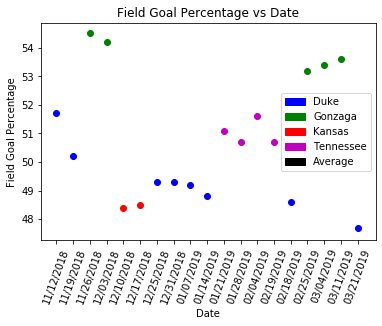

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

t_cols = {'Duke':'b', 'Gonzaga':'g', 'Kansas':'r', 'Tennessee':'m', 'Average': 'k'}

# we need to create a custom legend so points Teams aren't repeated

patches = [mpatches.Patch(color=v, label=k) for k, v in t_cols.items()]

for index in rank1s.index:
    if index in dfs.keys():
        curr_y = dfs[index].loc[dfs[index]['Name'] == rank1s[index]]['FG%'].values[0]
        plt.scatter(index, curr_y, c=t_cols[rank1s[index]])

plt.title('Field Goal Percentage vs Date')
plt.xlabel("Date")
plt.ylabel("Field Goal Percentage")
plt.xticks(rotation=70)
plt.legend(handles=patches)
plt.show()

### <a id="Average Statistics Graph">3.3 Average Statistics Graph</a>

Unfortunately Field Goal Percentage doesn't seem to stay very consistent throughout the season for rank 1. However, we can
see that the teams themselves hold consistent numbers during the season. Since we see that not all stats are going to show
the entire picture for rank 1, it may be a good idea to also add the average values to try to get a better picture of 
where the rank 1 teams stats stand. Now we'll graph a few more stats with the average added.

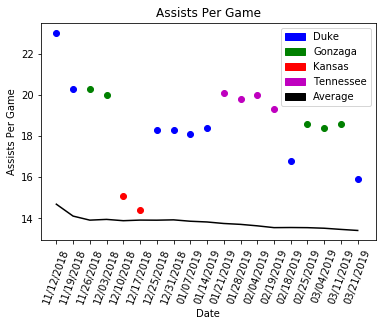

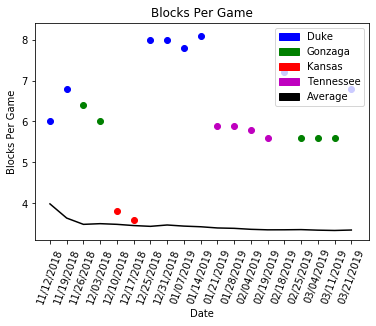

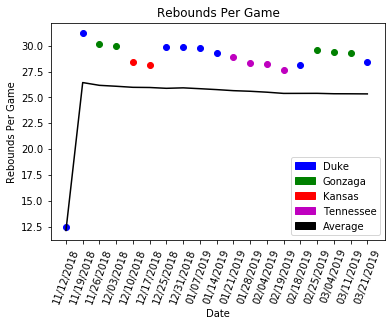

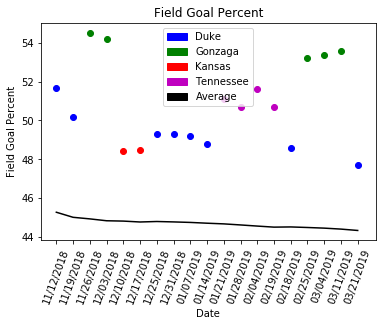

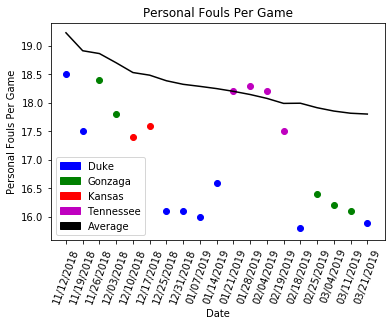

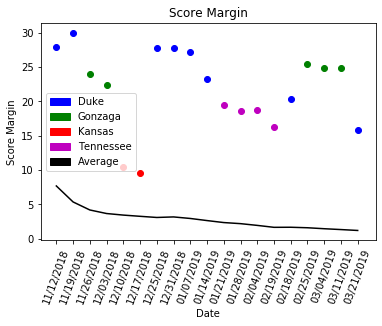

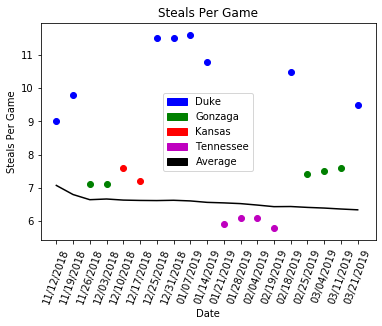

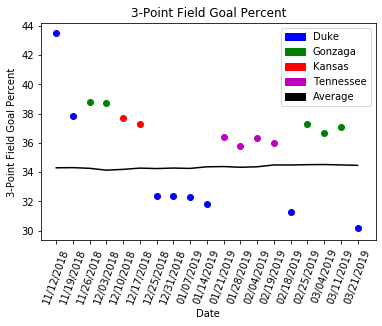

In [14]:
stats_to_name = {"TOPG" : "Turn Overs Per Game",
                 "APG" : "Assists Per Game",
                 "BKPG" : "Blocks Per Game",
                 "RPG" : "Rebounds Per Game",
                 "FG%" : "Field Goal Percent",
                 "OPP FG%" : "Opposition Field Goal Percent",
                 "PFPG" : "Personal Fouls Per Game",
                 "SCR MAR" : "Score Margin",
                 "STPG" : "Steals Per Game",
                 "3FG%" : "3-Point Field Goal Percent",
                 "FT%" : "Free Throw Percent",
                 "REB MAR" : "Rebound Margin",
                 "3PG" : "3-Points Per Game",
                 "Ratio" : "Assist to Turnover Ratio"}
stats_to_graph = ["APG", "BKPG", "RPG", "FG%", "PFPG", "SCR MAR", "STPG", "3FG%"]

for stat in stats_to_graph:
    dates = []
    avgs = []
    for index in rank1s.index:
        if index in dfs.keys():
            dates.append(index)
            curr_y = dfs[index].loc[dfs[index]['Name'] == rank1s[index]][stat].values[0]
            plt.scatter(index, curr_y, c=t_cols[rank1s[index]])
            avgs.append(dfs[index][stat].mean())
    plt.plot(dates, avgs, c=t_cols['Average'])
    plt.title(stats_to_name[stat])
    plt.xlabel("Date")
    plt.ylabel(stats_to_name[stat])
    plt.xticks(rotation=70)
    plt.legend(handles=patches)
    plt.show()
    

From these graphs, if one stat is very important to being rank 1, we'd expect all the teams to have a very similar
value for such stats. However it seems all of the stats, except 3-point field goal percentage and rebounds per game,
have a very large variations in values for week to week. We can see however that each team tends to keep fairly 
consistent on each stat from week to week. 3-point field goal percentage being more consistent would lead us to 
believe this is a more important stat to being rank one than others. 

We can see that even though the number one ranked team doesn't seem to lean on any one stat they excel comparted to 
average team in Division 1. There are are a couple stats, such as Steals Per Game, where Tennessee is worse than the
average, and 3-point field goal percentage where Duke is below average in the later half of the season, but outside
these two occurrences it's clear these teams outperform most of the Division.

### <a id="Statisics VS Win Percentage">3.4 Statisics VS Win Percentage</a>

We now create multiple scatter plots of a statistic on the x axis, and the win percentages of all the teams on the 
y axis. We do this by creating a list of statistics we want to plot against win percentage, and then using matplotlib
we create multiple plots, each with a unique name. We use dropna() to remove any missing values. Since we only want to 
view the general trends in the data, it is not important to keep every value to plot the data. We will use the scatter 
plots to determine which statistics are the best to predict a win for any college basketball team, given certain inputs.

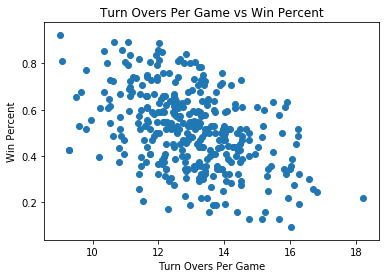

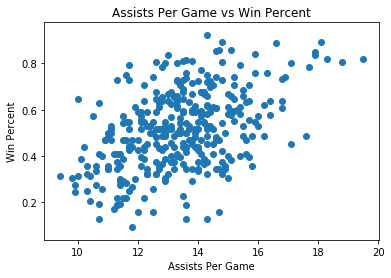

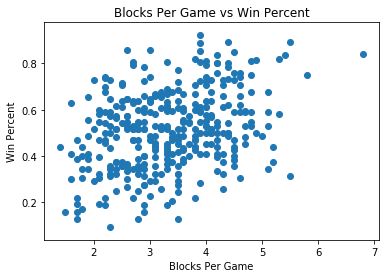

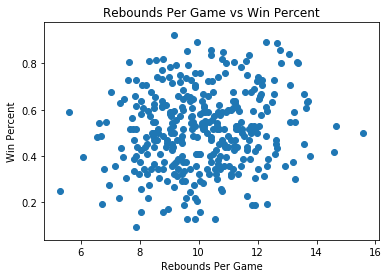

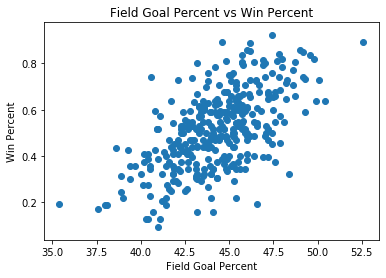

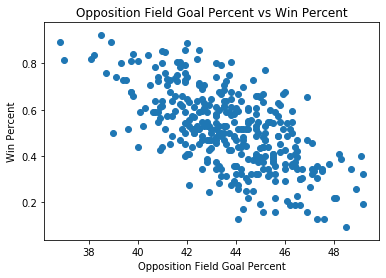

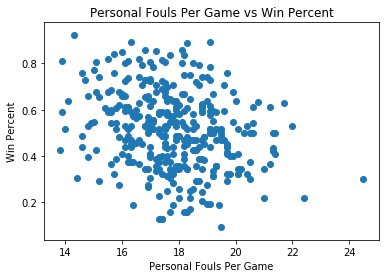

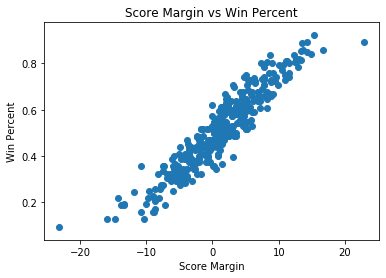

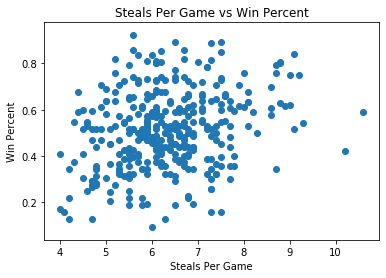

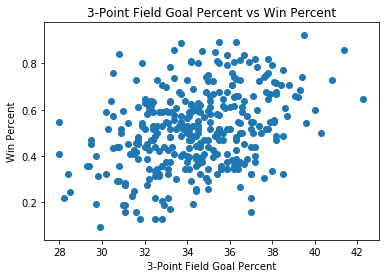

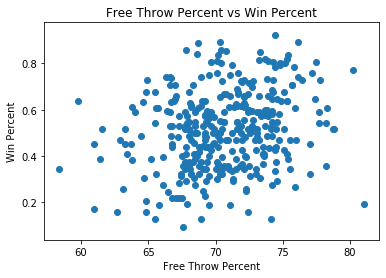

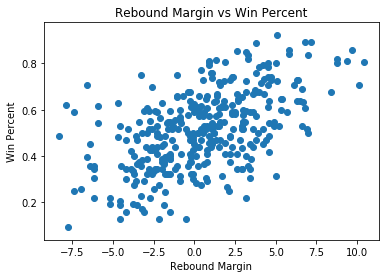

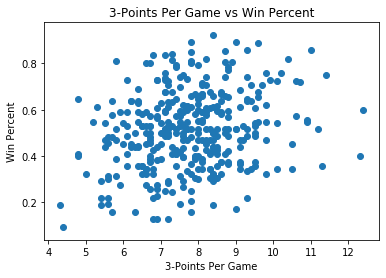

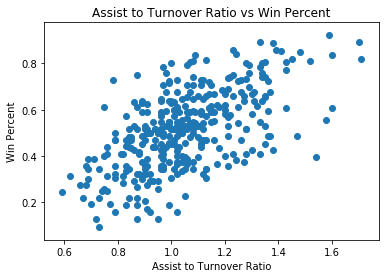

In [15]:
stats_to_graph = ["TOPG", "APG", "BKPG", "RPG", "FG%", "OPP FG%", "PFPG",
                  "SCR MAR", "STPG", "3FG%", "FT%", "REB MAR", "3PG", "Ratio"]

# iterate the stats and make a plot for each one
for stat in stats_to_graph:
    # get the values for the end of season data, dropping NAN values
    plt.scatter(dfs['04/08/2019'][stat].dropna(), dfs['04/08/2019']["Win%"].dropna())

    # set the graph labels
    plt.xlabel(stats_to_name[stat])
    plt.ylabel("Win Percent")
    plt.title(stats_to_name[stat] + " vs Win Percent")

    plt.show()

From the graphs, it is clear that certain statistics will provide insight to which teams are going to win a game. Some
statistics, like score margin (the average amount a team wins a game over the opponent), present a near perfect relation
to win percentage. However, this cannot be used in the regression model since it is a data leakage problem (meaning the 
prediction data implicitly contains the result). This means our predictions would be putting too much value in the 
results for the score margin. You can read more about data leakage at this link from Towards Data Science. 
https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742. 

Other statistics do not pose such a problem and still show a general trend following the win percentage. Some of these
statistics show a negative trend, meaning that the higher the statistic, the more likely it is a team will lose, and 
others show a positive trend, meaning the higher the statistic the more likely a team is to win. Positive trends are 
seen in the rebound margin, free throws per game, 3-Point field goal percent, steals per game, assists per game , and 
blocks per game statistics, while negative trends are shown in the turn overs per games and opposition field goal 
percent. Some data shows little correlation to the win percent, such as the personal fouls per game and rebounds per 
game. The statistics with trends will be used later in the predictive regression model.

## <center><a id="Machine Learning">Machine Learning</a></center>

Now that we have looked into what our data is and cleaned it up, we can start trying to predict what team will win a game
based on it's to date statistics in a given season. The statistics we decided to use for our model are as follows:
Blocks per game, Field Goal Percentage, Opponent Field Goal Percentage, Personal Fouls per game, Steals per game, 3 point
Field Goal Percentage, Free Throw Percentage, Rebound Margin, and Assist to Turnover ratio.

These stats were chosen, because they seemed to have the highest correlation with win rate. You'll notice that we did not
include scoring margin in our models inputs even though it had a very strong correlation with win rate.
This is because it is an example of data leakage. Data leakage is when we give our model information it shouldn't have 
make predictions. We shouldn't be giving our model scoring margin, because this statistic has information about if a team
is winning or not. We do not want our models to have the information of who won or who lost to do this exact prediction.


First we have to prepare our data, by creating x, y pairs. The x values being a list of the statistics from each team, and 
the y values being which team won. 

In [16]:
stats_to_use = ["BKPG", "FG%", "OPP FG%", "PFPG",
                "STPG", "3FG%", "FT%", "REB MAR", "Ratio"]

scores = scores.sample(frac=1).reset_index(drop=True)

#team1, team2, winner, date

y_setup = []
cross_over = len(scores) / 2
for index, row in scores.iterrows():
    if index < cross_over:
        curr = (row['win_team'], row['lose_team'], 0, row['date'])
    else:
        curr = (row['lose_team'], row['win_team'], 1, row['date'])
    y_setup.append(curr)

First we need to setup the games so we have some games were team 1 wins, and some where team 2 wins. To do this we will
randomize the data, so there is no bias about which teams get picked as team 1 and which get picked as team 2. Then we
set the winning team as team 1 for the first half of the dataframe and the losing team as team 1 for the second half. We
want to have an even number of each prediction class as to not bias our model to one prediction.

In [17]:
y = []
xs = []
for result in y_setup:
    date = result[3]
    if date not in dfs.keys():
        continue
    if set(stats_to_use).issubset(set(dfs[date].columns)):

        if result[0] not in dfs[date]["Name"].values:
            continue
        if result[1] not in dfs[date]["Name"].values:
            continue
        team1_stats = [dfs[date][dfs[date]["Name"] == result[0]][stat].values[0] for stat in stats_to_use]
        team2_stats = [dfs[date][dfs[date]["Name"] == result[1]][stat].values[0] for stat in stats_to_use]
        team1_stats.extend(team2_stats)
        xs.append(team1_stats)
        y.append(result[2])
        

Next we create the actual x, y pairs. Unfortunately some of the data we recieved from the NCAA website does not contain
every team for every week or every stat for every week. So, we need to omit these games from our training since we do not
have the information available to us to create inputs for the model. This code simple stacks the stat values for team 1 and 
team 2 into a list, xs, and the result of the game into another list, y. After this, the 
data is ready to be used to create our regression model.

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit

sv = SVC()
lr = LogisticRegression()
rfc = RandomForestClassifier()

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
svc_score = cross_val_score(sv, xs, y, cv=cv)
print(svc_score)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
lr_score = cross_val_score(lr, xs, y, cv=cv)
print(lr_score)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
rfc_score = cross_val_score(rfc, xs, y, cv=cv)
print(rfc_score)

[0.71252882 0.69946195 0.73174481 0.69792467 0.70868563 0.71637202
 0.73328209 0.70561107 0.70176787 0.70714835]
[0.72943889 0.72790161 0.7255957  0.72252114 0.72021522 0.71329746
 0.74250576 0.70176787 0.71867794 0.71867794]
[0.71329746 0.70253651 0.73097617 0.71714066 0.68024596 0.70561107
 0.72328978 0.70023059 0.71176018 0.71099154]


/home/chris/git/final320project/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/chris/git/final320project/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

With the data prepared, we can create 3 different models to predict the winner of a basketball game between two 
teams. We chose 3 regression models for our project. These are a support vector machine, a logistic regression, and a
random forest classifier. We then use ShuffleSplit to randomize the data put in the models. The cross validation score
tells us how accurate our models were in predicting wins for a basketball game. Cross Validation also allows us to take
many different samplingings of our data to see how well our model is generalizing to unseen data. To read more about
Cross Validation, check out this [guide](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f).
 Based on the results, each model seems to have about 70-percent prediction accuracy. 

## <center><a id="Conclusion">Conclusion</a></center>

Machine learning has become more and more popular. The idea of data science starts from business analysis. Business analysts use statistics to predict and determine whether a decision or a contract will generate profit. From that idea, people started to incorporate data science into other aspects, including sports. People try to build models that can predict whether a certain team will win a game.

We started from data collection and data cleaning. This process is the bulk of all data analysis. We need to research different data sets and find ones that we suits our need. We then continue to read the data and clean the data. We use pandas as our primary dataframe because they provide a good representation for the data. We use techniques such as merging, droping and adding columns, mapping, and others to transform our data into something that is interpretable.

We then display some graphs to get a view of how the data look like. We use matplotlib as our graphing tool and we made scatter plots to see how the different statistic interact with each other. We saw that some statistics such as field goal percentage did not have a strong correlation. We then graph different statistics with the average and win rate and try to find specific statistics that have a strong correlation with win rate. We then decided that those statistics might be usefull to build our models.

After cleaning our data and choosing specific parameters, we can finally build our predictive models. We used our box scores dataset to train our models. We used ScikitLearn and SciPy as our main library because they have a lot of different regression models that we can use. We did logistic regression, random forests, and Support Vector Classification (SVC) which are all models that we use to predict the winning team.

Overall there are so much more to explore in the data science world. This tutorial is just a sneak peek into data science in the sports world. Today, we have countless of data for everything and you can definately use the skills in this tutorial for other aspects. If you are interested in learning more about data science in basketball, the https://towardsdatascience.com/tagged/basketball page displays a lot of interesting data science articles on basketball. Thank you so much for reading our tutorial and we hope that this tutorial may spark the inner data scientist in you.

